In [47]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
import matplotlib 

from itertools import product

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

import h5py
from dustapprox.models import PrecomputedModel

import emcee
import corner

In [48]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '../Data/230420_CAResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [49]:
### Dustmap coordinates
distance = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 200)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

(200, 200, 200)


shape: (601, 601, 161)
(601, 601, 161)


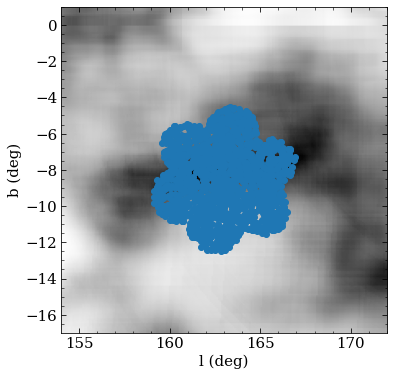

In [50]:
### Get Vergely+ (2022) dustmap for same points as Bayestar, now that it's in dustmaps
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')
vergely = vergelyquery(coords) * A0Coeff

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.scatter(CA_meta['GLON'], CA_meta['GLAT'])
plt.show()

In [51]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [52]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [53]:
loff = 1
boff = 1
l_cen, b_cen, = (163 + loff , -8.4 + boff)
s= select_stars(CA_meta, l_cen, b_cen, radius = .25)
s1 = select_stars(CA_meta, l_cen +1 , b_cen +1 , radius = .23)
s2 = select_stars(CA_meta, l_cen -1 , b_cen -1 , radius = .23)
s3 = select_stars(CA_meta, l_cen - 2, b_cen - 2, radius = 0.23)

In [54]:
def find_nearest(ll, bb):
    l_sel = l_
    b_sel = b_

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[b_ind, l_ind, :]) #needs to be b then l then :

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

def Differential_Amplitude(dAv_dd, dd):
     return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd

def dAV_dd_array(l, b, bins, star_dist, dmap_dist = distance):
    l_ind, b_ind = find_nearest(l, b)
    verg_sightline = np.copy(vergely[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    dAVdd_all = np.zeros(len(bins)-1)
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])
        dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

    return dAVdd, dAVdd_all

def dAV_dd_dustmap(l_cen, b_cen, radius, distance_bins):
    

    return

In [55]:
class sightline:
    ### Container object for stars, sightline dAV_dd, velocity, and spaxel assignment.
    def __init__(self, stars, bins = None, **kwargs):
        self.stars = stars
        dist = self.stars['DIST']

        if bins is not None:
            h = np.histogram(dist, bins)[0]
            self.bins = np.insert(bins[1:][h != 0], 0, bins[0])
            self.bin_inds = np.digitize(dist, bins)
        else:
            self.make_bins()
            self.bin_inds = np.digitize(dist, self.bins)  
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs()
        self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        
    def make_bins(self, binsep = 10, dmin = 0):
        ### Assigns stars to distance bins if bins are not already supplied.
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), 0, dmin))

        i = 0
        while i >= 0:
            next_bin = np.min(bins[bins > bins[i]])
            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins
            
    def get_DIBs(self):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))

        # dAVdd = np.zeros(len(self.bins))

        for i in range(len(self.stars)):
            star = self.stars[i]
            res_hdul = fits.open(get_ca_res(star['FILE']))
            signals[i, :] = res_hdul[1].data[window]
            signal_errs[i, :] = res_hdul[2].data[window]
            l, b = star['GLON'], star['GLAT']
            dAVdd[i], dAVdd_all[i] = dAV_dd_array(l, b, self.bins, star['DIST'])
        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        print(self.voxel_dAVdd.shape)
        # self.dAVdd = dAV_dd_array(np.median(self.stars['GLON']), np.median(self.stars['GLAT']), 
        #                           self.bins, np.max(self.bins))

    def model_signals(self, rvelo, dAVdd = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        # print('dAVdd shape: ', dAVdd.shape)
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins) - 1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = Differential_Amplitude(dAVdd, self.bins[1:]-self.bins[:-1])

        # def single_signal(bin_index, amp = amp):
        #     amp[bin_index+1:] = 0
        #     voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        #     summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        #     continuum = lambda x, m, b : m * (x - lambda0) + b
        #     cont = continuum(wavs_window, m, b)

        #     return summed_DIB  + cont 
        def single_signal(amp, bindex):
            amp[bindex+1:] = 0
            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)

            return summed_DIB  + 1 

        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = Differential_Amplitude(dAVdd_star, 5)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals
            
    ### + A vector of dAV_dd prior (e.g. sigma) with sigma_dAV_dd(d > d_star) = 0 


    ### + A vector of velocities per distance bin

    ### Consider Gaussian fitting each feature first


(6,)
(3,)
(5,)
(3,)


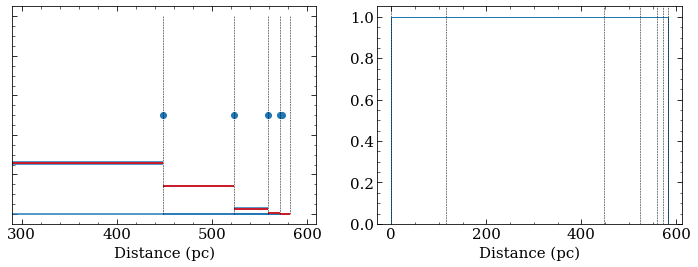

In [56]:
a = sightline(CA_meta[s])
a1 = sightline(CA_meta[s1])
a2 = sightline(CA_meta[s2])
a3 = sightline(CA_meta[s3])


fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
ax = axs[0]

for i in range(len(a.bins)-1): 
    ax.hlines(a.dAVdd[:, i], a.bins[i], a.bins[i+1])
    ax.hlines(a.voxel_dAVdd[i], a.bins[i], a.bins[i+1], color = 'r')

ax.plot([a.bins, a.bins], [np.zeros(len(a.bins)), np.ones(len(a.bins))], c='k', linestyle = 'dashed', linewidth = 0.5)
ax.scatter(CA_meta[s]["DIST"], np.ones(len(CA_meta[s])) * 0.5)
ax.set_xlabel('Distance (pc)')
ax.set_yticklabels('')
ax.set_xlim(290, 610)
# axs[0].plot(a.bins[1:], a.dAVdd.T)



axs[1].hist(a.stars['DIST'], a.bins, histtype = 'step')
ymin, ymax = axs[1].get_ylim()
axs[1].set_ylim(ymin, ymax)
axs[1].plot([a.bins, a.bins], [np.zeros(len(a.bins)), ymax * np.ones(len(a.bins))], c='k', linestyle = 'dashed', linewidth = 0.5)
axs[1].set_xlabel('Distance (pc)')
fig.set_facecolor('white')
plt.show()

In [57]:
np.sum(a.voxel_dAVdd * 5)

2.207222943904758

In [58]:
a.dAVdd.shape

(6, 6)

In [59]:
# for i in range(len(a.stars)):
#     # star = a.stars[i]
#     plt.plot(a.bins[1:], a.dAVdd[i, :])
#     plt.show()

In [60]:
# signals = a.signals
# signal_errs = a.signal_errs
# voxel_dAv_dd = a.dAVdd
# voxel_dist = a.bins[1:]
### The issue is that now I have multiple stars in each bin, so I'm going to need to figure that part out
### NEXT WEEK


# print(len(signals), len(signal_errs), len(voxel_dAv_dd), len(voxel_dist))

# def make_signals(rvelo, m = 0, b = 1, dAv_dd = voxel_dAv_dd, dist = voxel_dist, sigma0=sigma0, **kwargs):
#     signals = np.zeros((len(dist), len(wavs_window)))
#     amp = Differential_Amplitude(dAv_dd, dd = 5) # CONVERT THIS


#     peak_wavelength = dopplershift(rvelo)
#     wavs_grid = np.tile(wavs_window, (len(dist), 1))
#     voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))

#     def single_signal(dist_max, i, amp = amp):
#         # print(dist_max)
#         amp = -np.copy(amp)
#         amp[dist > dist_max] = 0
#         voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
#         summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
#         continuum = lambda x, m, b : m * (x - lambda0) + b
#         cont = continuum(wavs_window, m, b)

#         return summed_DIB  + cont
    

#     for i in range(len(dist)):
#         dist_max = dist[i]
#         signals[i, :] = single_signal(dist_max, i)
    
#     signals = signals #+ continuum(wavs_window, m, b)[np.newaxis, :]
#     return signals


In [61]:
# model_signals(self, rvelo, dAVdd = None):
signals = np.zeros(a.signals.shape)
signal_errs = np.zeros(a.signals.shape)
def loglikely_2(v, av, sl = a, **kwargs):

    # v = p[:int(len(p)/2)]
    # av = p[int(len(p)/2):]
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1)

    signal = sl.signals
    sigma = sl.signal_errs

    # print('loglikely av shape' ,av.shape)
    val = - 0.5 * np.nansum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2))
    if np.isnan(val):
        # print('fail loglikely')
        return -np.inf
    else:
        return val
    # return - 0.5 * np.sum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) 

def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        # print('logprior v -inf')
        return -np.inf
    return 0.0

def logprior_davdd(av, AV_base = 5, AV_max = 10):   
    if (np.any(np.abs(av - AV_base) > AV_max)):
        # print('av -inf')
        return -np.inf
    if ((np.any(av < 0))):
        # print('logprior av -inf')
        return -np.inf
    return 0.0

def logprior_davdd_reg(av,sl, mask = None, **kwargs):
    # print(av.shape)
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1) # FOR NOW 

    mask = av == 0.0
    av[mask] = np.nan

    # avmed = np.nanmedian(av, axis = 0)
    # avstd = np.nanstd(av, ddof = 1,  axis = 0)
    # avstd[np.isnan(avstd)] = 0.2

    avmed = sl.voxel_dAVdd
    avstd = sl.voxel_dAVdd_std 
    # return 0
    return 1e-2 * np.sum( - 0.5 * (av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2)) # first part might not be needed

    # return np.sum(np.log(1/(avstd[:, np.newaxis] * np.sqrt(2 * np.pi ))) - 0.5 * (av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2)) # first part might not be needed

def logprob_2(p, sl = a, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim)
    # print(av.shape)

    lp = logprior(v, **kwargs)
    lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
    lp_davdd_reg = logprior_davdd_reg(av, sl, **kwargs)

    if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
        # print('fail logprob')
        return -np.inf
    return lp + lp_davdd + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs)

In [62]:
# nwalkers = 100
# ndim = len(a.voxel_dAVdd) 
# ndim_amp = int(2 * ndim)
# init = 5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
# init[:, ndim:] = np.abs(a.voxel_dAVdd[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
# print(init[:, ndim:])
# print(init.shape)
# init = init[0 , :]
# logprob_2(init, AV_base = a.dAVdd)

In [63]:

def MCMC(sl, steps = 1000, nwalkers = 100):
    ndim = len(sl.voxel_dAVdd) 
    ndim_amp = int(2 * ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl, 'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs})
    init = 7.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
  
    init[:, ndim:] = np.abs(sl.voxel_dAVdd[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
    print(init.shape)
    sampler.run_mcmc(init,  steps);
    
    return sampler, ndim, ndim_amp


def MCMC_scary(sl, steps = 1000, nwalkers = 100):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl,  'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs})
    init = 7.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
  
    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
    # plt.hist(init[:, ndim:])
    print(init.shape)

    
    sampler.run_mcmc(init,  steps);
    
    return sampler, ndim, ndim_amp

In [64]:
stp = 1000
sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

(500, 42)


In [ ]:
sampler.chain.shape

(500, 1000, 42)

42


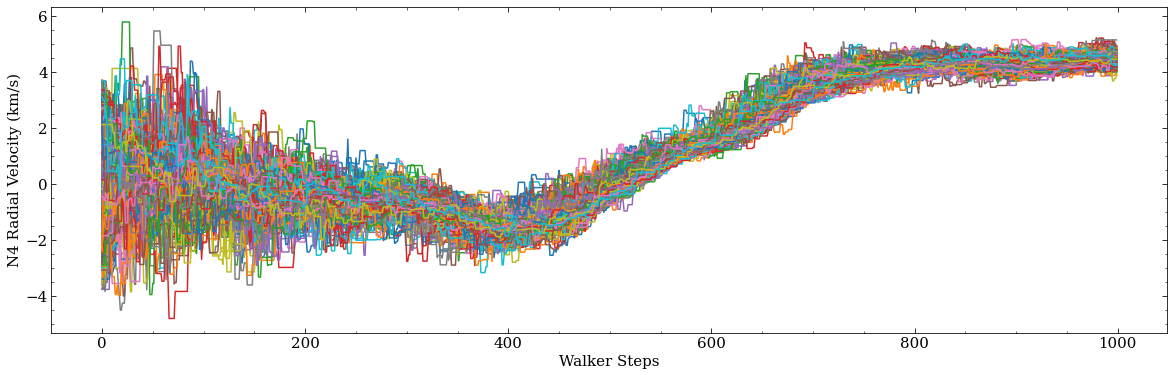

In [ ]:
def burnin(sampler, i, sl=a, label = ''):
    fig, ax = plt.subplots(figsize = (20, 6))
    ndim = sampler.chain.shape[-1]
    nbin = len(sl.voxel_dAVdd)
    print(ndim)
    if range(ndim)[i] < int(nbin):
        label = 'N{} Radial Velocity (km/s)'.format(i)
    else:
        label = 'N{} dA(V)/dd (mag/pc)'.format(i - int(ndim/2))

    normalize = matplotlib.colors.Normalize(-10, 10)
    cmap = matplotlib.cm.viridis
    cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
    colors = cmap(np.linspace(0,1,ndim))

    # for i in range(ndim):
    walkers = sampler.chain[:,:,i].T
    points = ax.plot(walkers)

    cutoff = 50
    median = np.median(walkers[cutoff:, :])
    perc16err =  median - np.percentile(walkers[cutoff:, :], 16) 
    perc84err =  np.percentile(walkers[cutoff:, :], 84) - median
    stdeviation =  np.std(walkers[cutoff,:], ddof = 1)


    # plt.errorbar(x = 500 + 0.05 * 500, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

    # fig.colorbar(cmappable, label = 'Velocity ')
    ax.set_xlabel("Walker Steps")
    ax.set_ylabel(label)
    plt.show()

burnin(sampler, 4, sl = a, label = '')


In [ ]:
def make_corner(sampler, labels):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, 50:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

# labels = ['RVELO1', 'RVELO2', 'RVELO3', 'RVELO4', 'RVELO5', 'RVELO6', 'RVELO7']
# make_corner(samp1, labels = labels)
# make_corner(sampler, labels = None)

In [ ]:
sampler.chain.shape

(500, 1000, 42)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(42,)
(6, 95)


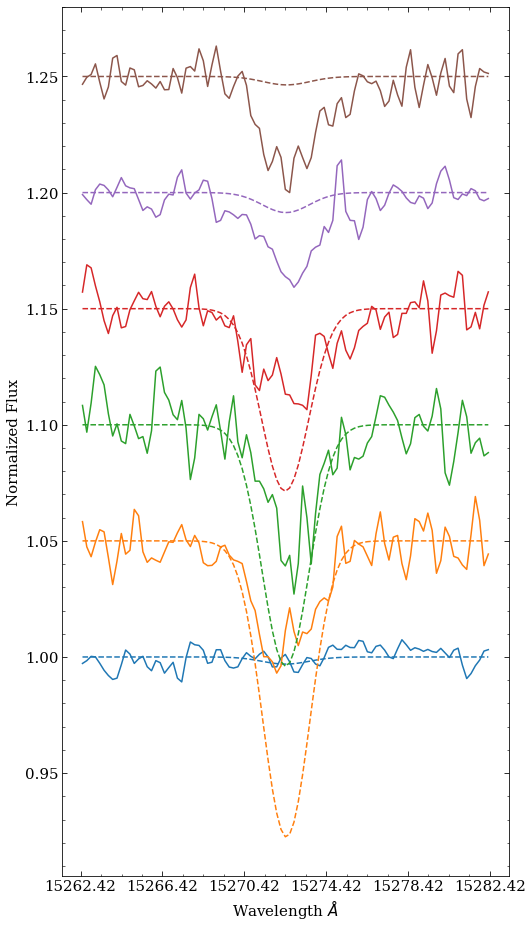

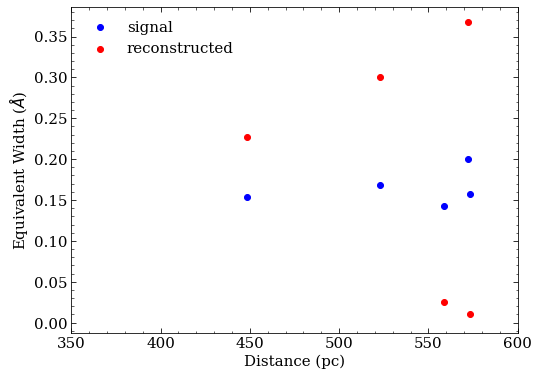

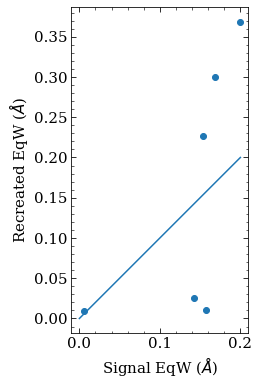

In [ ]:
def plot_DIBS(sampler, sl = a):
    fig, ax = plt.subplots(figsize = (8, 16))
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    # median_3 = np.nanmedian(samples[50:, 3])
    # median_4 = np.nanmedian(samples[50:, 4])
    # median_5 = np.nanmedian(samples[50:, 5])
    # median_6 = np.nanmedian(samples[50:, 6])
    # print(samples.shape)
    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    print(medians.shape)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(ndim, -1)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    signal_recreated = sl.model_signals(med_velo, dAVdd = med_dAV_dd)
    print(signal_recreated.shape)
    for i in range(len(sl.voxel_dAVdd)):
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[i, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[i, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dashed',)# label = 'recreated signal')
        # ax.plot(wavs_window, signal_recreated[2, :], color = 'C1', linestyle = 'dashed')

    ax.legend(loc = 'lower left')

    ax.set_xlabel('Wavelength $\AA$')
    ax.set_ylabel('Normalized Flux')
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))

    plt.show()

    fig, ax = plt.subplots(figsize = (8,6))

    realDIB_eqw = np.trapz(-(sl.signals-1), x = wavs_window, axis = 1)
    fakeDIB_eqw = np.trapz(-(signal_recreated-1), x = wavs_window, axis = 1)
    ax.scatter(sl.stars['DIST'], realDIB_eqw, c='b', label = 'signal')
    ax.scatter(sl.stars['DIST'], fakeDIB_eqw, c = 'r', label = 'reconstructed')
    ax.legend()
    ax.set_xlim(350,  600)
    ax.set_xlabel("Distance (pc)")
    ax.set_ylabel('Equivalent Width ($\AA$)')
    plt.show()

    fig, ax = plt.subplots(figsize = (8, 6))
    ax.scatter(realDIB_eqw, fakeDIB_eqw)
    ax.set_xlabel('Signal EqW ($\AA$)')
    ax.set_ylabel('Recreated EqW ($\AA$)')
    ax.set_aspect('equal')
    ax.plot((0, .2), (0, .2))
    plt.show()

plot_DIBS(sampler, sl = a)

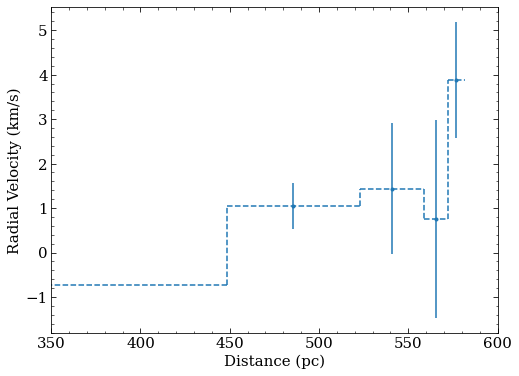

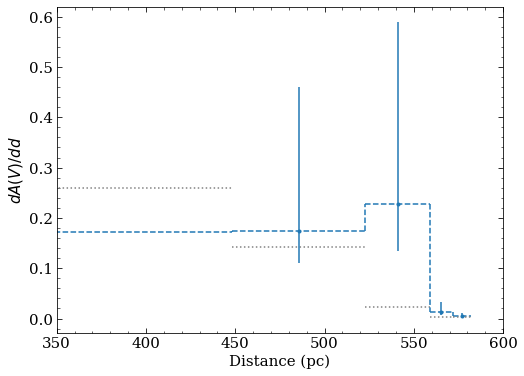

In [ ]:
def plot_velo(sampler, sl  = a):
    fig, ax = plt.subplots(figsize = (8,6))
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))


    medians = np.nanmedian(samples[50:, :], axis = 0)
    stdevs = np.nanstd(samples[50:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]

    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    for i in range(len(sl.bins)-1): 
        ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
        if i < len(sl.bins) -2:
            ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')
    ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.')
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

def plot_dAVdd(sampler, sl  = a):
    fig, ax = plt.subplots(figsize = (8,6))
    nbin = len(sl.voxel_dAVdd)
    nstar = len(sl.stars)
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))


    medians = np.nanmedian(samples[50:, :], axis = 0)
    stdevs = np.nanstd(samples[50:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]

    med_dAV_dd = medians[ndim:].reshape(nstar, ndim)
    med_dAV_dd[np.isnan(med_dAV_dd)] = np.nan
    dAVdd_report = np.nanmedian(med_dAV_dd, axis = 1)
    dAVdd_scatter_report = np.nanstd(med_dAV_dd, ddof = 1, axis = 1)

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    std_dAV_dd = stdevs[ndim:]
    dAV_dd16 = np.percentile(samples[50:, :], 16, axis = 0)[ndim]
    dAV_dd84 = np.percentile(samples[50:, :], 84, axis = 0)[ndim]

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    for i in range(len(sl.bins)-1): 
        ax.hlines(dAVdd_report[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
        ax.hlines(sl.voxel_dAVdd[i], sl.bins[i], sl.bins[i+1], linestyle = 'dotted', color ='grey')

        if i < len(sl.bins) -2:
            ax.vlines(sl.bins[i+1], dAVdd_report[i], dAVdd_report[i+1], linestyle = 'dashed')
    ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , np.median(med_dAV_dd, axis = 1), yerr = (dAVdd_report - dAVdd_scatter_report, dAVdd_report + dAVdd_scatter_report), fmt = '.')
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel(r'$dA(V)/dd$')
   

plot_velo(sampler, sl = a)
plt.show()
plot_dAVdd(sampler, sl = a)
plt.show()